# Fast Force Field Fitting (F4) EXESS based data generation with a SMIRNOFF force field fit

In this notebook we'll generate all of the QM data required to fit a force fields from EXESS (using the F4 data generation module) and then we will fit a SMIRNOFF type forcefield (using the F4 smirnoff fit module)

# 0) Complete example

See the sample notebook for a complete demonstration.

# 1) Setup

## 1.0) Imports

In [38]:
import json
import os
from pathlib import Path
import py3Dmol
import time
import IPython.display
import matplotlib.pyplot as plt

import rush

## 1.1) Configuration

In [9]:
EXPERIMENT = "rush-py f4 fitting demo"
SYSTEM = "GLYCINE"
TAGS = ["qdx", EXPERIMENT, SYSTEM]

In [10]:
# |hide
WORK_DIR = Path.home() / "qdx" / EXPERIMENT

if WORK_DIR.exists():
    client = rush.Provider(workspace=WORK_DIR)
    await client.nuke(remote=False)

os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(WORK_DIR / ".rush", exist_ok=True)
YOUR_TOKEN = os.getenv("RUSH_TOKEN")
os.chdir(WORK_DIR)

Build our client

In [12]:
os.environ["RUSH_TOKEN"] = YOUR_TOKEN

client = rush.build_blocking_provider_with_functions(batch_tags=TAGS)

Bad type! 1
Bad type! 0
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 4
Bad type! 5
Bad type! 6
Bad type! 250
Bad type! 251
Bad type! 252
Bad type! 253
Bad type! 254
Bad type! 255
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 7
Bad type! 8
Bad type! 1
Bad type! 2
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 0
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 4
Bad type! 5
Bad type! 6
Bad type! 250
Bad type! 251
Bad type! 252
Bad type! 253
Bad type! 254
Bad type! 255
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad type! 2
Bad type! 7
Bad type! 8
Bad type! 1
Bad type! 2
Bad type! 3
Bad type! 1
Bad 

# 2) Preparation

## 2.1) QDXF input file

In [14]:
glycine_data = {
  "schema_version": "0.2.0",
  "geometry": [
    2.8315369813193936, -0.012276482655411019, -0.04420729297091298,
    2.0438584571382803, -0.3647395765421934, 0.5225107506788758,
    0.7986260557797081, 0.16232294621286594, 0.19982508170048197,
    0.7729295964771392, 1.3542568149628207, -0.18611420167642995,
    -0.45079196027516766, -0.5979484620124086, 0.2900217249171123,
    -1.2895410761554387, -0.08506625020890618, -0.2641130923373958,
    -0.7717366906036721, -0.7701304047747469, 1.3588383430620818,
    -0.25972755986510376, -1.9071847571482659, -0.2820847414426759,
    -0.6093307740571089, -1.9888247661570349, -1.2621106958515207,
    0.7462059815469474, -2.225070961683621, -0.24739224505533192
  ],
  "symbols": ["H", "O", "C", "O", "C", "H", "H", "N", "H", "H"]
}
qdxf_input = Path(WORK_DIR) / "glycine_input.qdxf.json"
with open(qdxf_input, "w") as f:
    json.dump(glycine_data, f)

# 3) F4 Data Generation

To fit a force field we first generate the QM data

## 3.0) Arguments to F4 data generation

In [21]:
help(client.f4_data_generation)

Help on function f4_data_generation in module rush.provider:

f4_data_generation(*args: typing_extensions.Unpack[tuple[Record, RushObject[Record]]], target: 'Target | None' = None, resources: 'Resources | None' = None, tags: 'list[str] | None' = None, restore: 'bool | None' = None) -> tuple[RushObject[Record]]
    generate torsional energy profiles for input molecules
    
    Module version:  
    `github:talo/F4/82071637cf6aab198594ddd743d4193f214e0944#f4_data_generation_tengu`
    
    QDX Type Description:
    
        in: F4DataGenerationParameters {
            use_rimp2: bool,
            use_rihf: bool,
            basis_set: string,
            grid_spacing_deg: u32,
            clear_working_directory: bool,
            fragment_torsion_jobs: bool
        };
        in: Object {
            size: u64,
            format: ObjectFormat[json | bin]?,
            path: @Topology {
                fragment_partial_charges: [_(f32)]?,
                labels: [string]?,
            

## 3.1) Running F4 data generation

In [60]:
F4_RESOURCES = {
    "gpus": 1,
    "storage": 1000,
    "storage_units": "MB",
    "walltime": 60,
}

In [61]:
(f4_data,) = client.f4_data_generation(
  {
    "basis_set": "STO-3G",
    "use_rihf": True,
    "use_rimp2": False,
    "fragment_torsion_jobs": True,
    "grid_spacing_deg": 15,
    "clear_working_directory": True
  },
  qdxf_input,
  resources=F4_RESOURCES,
)

In [62]:
f4_data = json.load(f4_data.download(filename="data.json", overwrite=True).open())

2024-09-12 15:13:16,634 - rush - INFO - Argument c10c1118-36ff-4ddc-bf07-87f4a2963c9e is now RESOLVING
2024-09-12 15:13:18,319 - rush - INFO - Argument c10c1118-36ff-4ddc-bf07-87f4a2963c9e is now ADMITTED
2024-09-12 15:13:30,324 - rush - INFO - Argument c10c1118-36ff-4ddc-bf07-87f4a2963c9e is now DISPATCHED
2024-09-12 15:13:37,066 - rush - INFO - Argument c10c1118-36ff-4ddc-bf07-87f4a2963c9e is now RUNNING
2024-09-12 15:16:31,433 - rush - INFO - Argument c10c1118-36ff-4ddc-bf07-87f4a2963c9e is now AWAITING_UPLOAD


## 3.2) Visualise the F4 data

In [63]:
def create_xyz_data(coords, symbols):
    xyz_data = f"{len(symbols)}\n\n"
    for i, (x, y, z) in enumerate(coords):
        xyz_data += f"{symbols[i]} {x} {y} {z}\n"
    return xyz_data

In [64]:
xyz_for_angle = {}
energy_for_angle = {}
for torsion_data in f4_data["dihedral_data"][0]:
    angle = torsion_data["angle"]
    xyz_for_angle[angle] = create_xyz_data(
        torsion_data["optimised_geometry"]["coords"], torsion_data["optimised_geometry"]["symbols"]
    )
    energy_for_angle[angle] = torsion_data["energy"]

Text(0.5, 1.0, 'Energy Profile for Dihedral Scan 1-2-4-7')

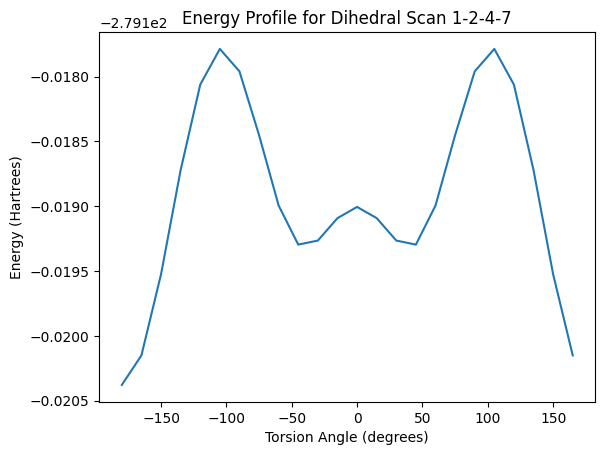

In [65]:
plt.plot(energy_for_angle.keys(), energy_for_angle.values())
plt.xlabel("Torsion Angle (degrees)")
plt.ylabel("Energy (Hartrees)")
plt.title(f"Energy Profile for Dihedral Scan {f4_data['dihedral_labels'][0]}")

In [68]:
# adjust the frame rate to your liking
FRAME_ANIMATION_TIME = 0.01

optimization_viewer = py3Dmol.view(width=800, height=600)
optimization_viewer.show()
for frame in xyz_for_angle.values():
    optimization_viewer.removeAllModels()
    optimization_viewer.addModel(frame, "xyz")
    optimization_viewer.setStyle({"stick": {}})
    optimization_viewer.zoomTo()
    optimization_viewer.render()
    IPython.display.clear_output(wait=True)
    IPython.display.display(optimization_viewer.show())
    time.sleep(FRAME_ANIMATION_TIME)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

None

# 4) SMIRNOFF Force Field Fitting

With the generated data, we now wish to fit a custom SMIRNOFF force field.

## 4.1) SMIRNOFF FF fitting parameters